# Inside the generative model

A look inside the continuous generative model under grid approximation.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys
import torch

from matplotlib import cm
from pylab import colorbar
from scipy.stats import norm, multivariate_normal, uniform
from torch.distributions import Normal, MultivariateNormal

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_agent, create_environment

mpl.style.use("seaborn-deep")

Chapter 2 primarily focuses on the likelihood, prior, and posterior. The likelihood was already pre-sliced for a particular value of interest in $y$ based on the input observation. In this notebook we examine the full joint distribution over states and observations - the generative model. To make this intuitive we will calculate the joint distribution as a grid approximation in a loop by assembling the conditional distribution $p(y \mid x)$ over all values of $x$ in the grid. This gives us the complete likelihood which can be used to visualize the generative model. We will avoid directly using multivariate distributions from the `scipy` library in this chapter.

First we create and environment and generate samples. To obtain the full likelihood, we to cover all external states in our grid and all sensory samples associated with these states. We do this by looping over `x_range`, setting each value in the range to the external state, and then generating $y$.

In [2]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1e-2   # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)


# Generate data for three different x_star values
N       = 500                                      # Number of samples
x_range = np.linspace(start=0.01, stop=5, num=N)   # Range of x_star
y       = np.zeros(N)                              # Empty array for i=30 samples

np.random.seed(95858)
for idx, x in enumerate(x_range):
    env.build(x)
    y[idx] = env.generate()

y = np.expand_dims(y, axis=1)

Next we turn to the generative model. Instead of a single slice of the likelihood over $x$ for a single value of $y$, we are interested in the likelihood over $x$ for all values of $y$. By passing in the $y$ we generated above, one for each $x^*$ in the grid, we can obtain this full likelihood. 

We also utilize a uniform prior so we can see the case when the generative model is just equal to the likelihood.

In [6]:
def generating_function(x, beta_0, beta_1):
    return beta_1 * x + beta_0

mu_y = generating_function(x_range, beta_0=3, beta_1=2)
likelihood = norm.pdf(y, loc=mu_y, scale=0.5)
prior      = uniform.pdf(x_range, loc=0.01, scale=5-0.01)

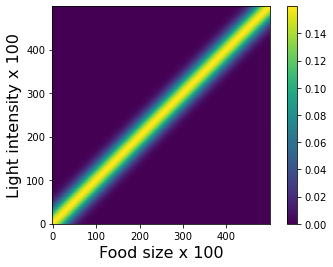

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(likelihood * prior, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(False)

Next we check to see the effect of the prior and how it encodes the notion that certain states may be more likely than others. To do so, we use a Gaussian prior whose mean is set to $m_x=1.25, 2.5$ or $3.75$.

In [8]:
prior_1 = norm.pdf(x_range, loc=1.25, scale=0.5)
prior_2 = norm.pdf(x_range, loc=2.5, scale=0.5)
prior_3 = norm.pdf(x_range, loc=3.75, scale=0.5)

gen_model_1 = likelihood * prior_1
gen_model_2 = likelihood * prior_2
gen_model_3 = likelihood * prior_3

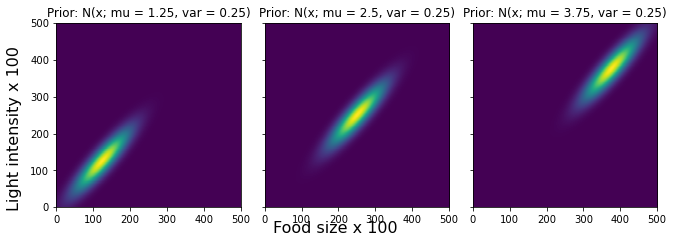

In [17]:
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(9.5,6.5), sharey=True)
axes[0].imshow(gen_model_1, origin="lower", cmap="viridis")
axes[1].imshow(gen_model_2, origin="lower", cmap="viridis")
axes[2].imshow(gen_model_3, origin="lower", cmap="viridis")

# Titles
axes[0].set_title("Prior: N(x; mu = 1.25, var = 0.25)")
axes[1].set_title("Prior: N(x; mu = 2.5, var = 0.25)")
axes[2].set_title("Prior: N(x; mu = 3.75, var = 0.25)")

# Tick range and grid
for ax in axes:
    ax.yaxis.set_ticks(np.arange(0, 600, 100))
    ax.xaxis.set_ticks(np.arange(0, 600, 100))
    ax.grid(False)

# Labels    
fig.supxlabel("Food size x 100", fontsize=16, y=0.27)
fig.supylabel("Light intensity x 100", fontsize=16)

fig.tight_layout()

Finally, we view the model in three dimensions.

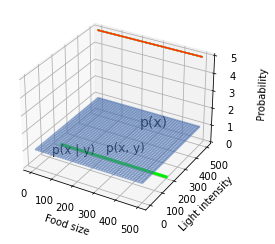

In [20]:
# Set up grid
X = np.linspace(0, 500, 500)
Y = np.linspace(0, 500, 500)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X 
pos[:, :, 1] = Y

# Set covariance matrix and joint distributions (Z)
cov_matrix = torch.tensor(np.array([[1764., 882.], [882., 1764.]]))

Z = MultivariateNormal(
    loc=torch.tensor([250, 250]),
    covariance_matrix=cov_matrix).log_prob(torch.tensor(pos))

fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.plot_wireframe(X, Y, np.exp(Z), cmap='viridis', 
                  rstride=12, cstride=12, alpha=0.5)

# Plot prior
prior = np.exp(Z).sum(axis=0) / 100
ax.contour(X, Y, np.tile(prior, [len(prior), 1]), zdir='y', offset=500, cmap=cm.jet)

# Plot likelihood
likelihood = Normal(
    loc= G(x_range, beta_0=3, beta_1=2), 
    scale=0.5).log_prob(torch.tensor(8))

likelihood = torch.tensor(np.exp(likelihood.tolist()))
posterior = likelihood * prior / sum(likelihood*prior)

ax.plot3D(
    np.linspace(0, 500, 500),
    200 * np.ones(500),
    posterior / 200, lw=3, c="#00ee00")

# ax.plot3D(
#     np.linspace(0, 500, 500),
#     275 * np.ones(500), 
#     likelihood / 9000, lw=3, c="#8B008B")

# Axis labels
ax.set_xlabel("Food size")
ax.set_ylabel("Light intensity")
ax.set_zlabel("Probability", labelpad=10)

# Add distribution labels
ax.text(210, 500, 0.0001, "p(x)", fontsize=14)
# ax.text(0, 200, 0.00002, r"$p(y \mid x)$", fontsize=12)
ax.text(0, 120, 0.00002, "p(x | y)", fontsize=12)
ax.text(190, 250, 0.00011, "p(x, y)", fontsize=12)

plt.show()


In [8]:
def generating_function(x, beta_0, beta_1):
    return beta_1 * x + beta_0

# full_gen_model = np.zeros((N, N))

# for x in range(x_range):
#     mu_y = generating_function(x, beta_0=3, beta_1=2)
#     norm.pdf(y, loc=mu_y, scale=0.5)

In [10]:
mu_y = generating_function(x_range, beta_0=3, beta_1=2)
full_likelihood = norm.pdf(y, loc=mu_y, scale=0.5)

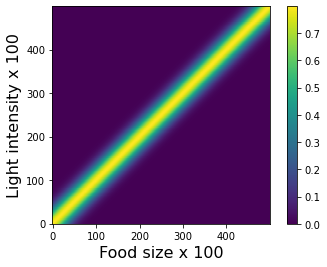

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(full_likelihood, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(False)

In [17]:
prior = norm.pdf(x_range, loc=1.25, scale=0.5)

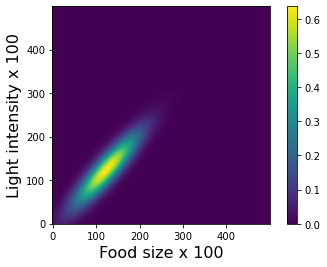

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(full_likelihood * prior, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(False)

## Scratch

In [ ]:
class StaticAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        self.likelihood = None
        self.prior = None
        
    def gm(self):
        return self.params.beta_1 * self.params.x_range + self.params.beta_0
        
    def generative_model(self, y: float):
        self.likelihood = norm.pdf(y, loc=self.gm(), scale=self.params.std_y)
        self.prior      = norm.pdf(x_range, loc=self.params.mu_x, scale=self.params.std_x)
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        gen_model = self.generative_model(y)
        evidence  = np.sum(gen_model, axis=0)
        posterior = gen_model / evidence
        return posterior

In [ ]:
def generating_function(x, beta_0, beta_1):
    return beta_1 * x + beta_0

full_gen_model = np.zeros((N, N))

for x in range(x_range):
    mu_y = generating_function(x, beta_0=3, beta_1=2)
    norm.pdf(y, loc=mu_y, scale=0.5)

In [6]:
""" Setup agent and infer hidden states """
probs = np.zeros((N, N))

for idx, x in enumerate(x_range):
    
    # Agent parameters
    agent_params = {
        "beta_0" : 3,    # Linear parameter intercept
        "beta_1" : 2,    # Linear parameter slope
        "std_y"  : 0.5,  # Likelihood standard deviation
        "m_x"    : x,    # Prior mean
        "s_x"    : 0.5,  # Prior standard deviation
        "x_range": x_range
    }

    # Initialize and build agent
    agent = create_agent(name="exact_linear", params=agent_params)
    agent.build(y)
    
    # Return generative movel
    gen_model = agent.model 
    
    # Append probabilities
    probs[idx] = gen_model


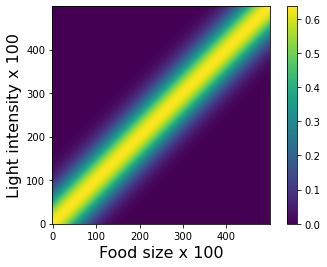

In [7]:
fig, ax = plt.subplots()
im = ax.imshow(probs, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(False)

In [8]:
def build_generative_model(x):
    # Agent parameters
    agent_params = {
        "beta_0" : 3,    # Linear parameter intercept
        "beta_1" : 2,    # Linear parameter slope
        "std_y"  : 0.5,  # Likelihood standard deviation
        "m_x"    : x,    # Prior mean
        "s_x"    : 0.5,  # Prior standard deviation
        "x_range": x_range
    }

    # Initialize and build agent
    agent = create_agent(name="exact_linear", params=agent_params)
    agent.build(y)
    
    # Return generative movel
    gen_model = agent.model 
    
    return gen_model


probs = np.zeros((N, N))
for idx, x in enumerate(x_range):
    gen_model = build_generative_model(x)
    probs[idx] = gen_model

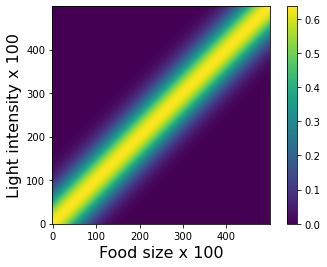

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(probs, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(False)

Next we check to see the effect of the prior and how it encodes the notion that certain states may be more likely than others. To do this we set re run the agent from before but pass in a prior each time the generative model is run. This way all generative models will be biased with a credibility pointing toward a specific value of $x$. The effect is less strong the more samples we have.

In [17]:
probs_1 = np.zeros((N, N))
probs_2 = np.zeros((N, N))
probs_3 = np.zeros((N, N))

# Prior mean = 1.25
for idx, x in enumerate(np.repeat(1.25, N)):
    gen_model = build_generative_model(x)
    probs_1[idx] = gen_model
    
# Prior mean = 2.5
for idx, x in enumerate(np.repeat(2.5, N)):
    gen_model = build_generative_model(x)
    probs_2[idx] = gen_model

# Prior mean = 3.75
for idx, x in enumerate(np.repeat(3.75, N)):
    gen_model = build_generative_model(x)
    probs_3[idx] = gen_model

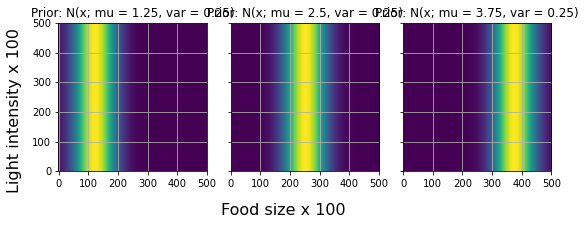

In [21]:
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,6.5), sharey=True)
axes[0].imshow(probs_1, origin="lower", cmap="viridis")
axes[1].imshow(probs_2, origin="lower", cmap="viridis")
axes[2].imshow(probs_3, origin="lower", cmap="viridis")

# Titles
axes[0].set_title("Prior: N(x; mu = 1.25, var = 0.25)")
axes[1].set_title("Prior: N(x; mu = 2.5, var = 0.25)")
axes[2].set_title("Prior: N(x; mu = 3.75, var = 0.25)")

# Tick range and grid
for ax in axes:
    ax.yaxis.set_ticks(np.arange(0, 600, 100))
    ax.xaxis.set_ticks(np.arange(0, 600, 100))
    ax.grid(None)

# Labels    
fig.supxlabel("Food size x 100", fontsize=16, y=0.27)
fig.supylabel("Light intensity x 100", fontsize=16)
   
fig.tight_layout()